### MILESTONE PROJECT 1 : FOOD VISION





In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-7dc42c23-1457-bcab-5596-66376b45bfa0)


In [ ]:
## Get Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-09 16:03:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-09 16:03:18 (77.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

# Use tensorflow datasets to download data


In [ ]:
#Get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
datasets_lists = tfds.list_builders()
print("food101" in datasets_lists)

True


In [ ]:
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True, # data gets returned in tuple format (data,label)
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteH302D3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteH302D3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the food101 dataset from tensorflow Datasets

To become one with data :-
* class Names
* The shape of our input data(image tensors) 
* The data type of our input data
* What the labels look like (eg. are they one hot encoded or are they label encoded)
* Do the labels match up with class names

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:

#Take one sample of the train data
train_one_sample=train_data.take(1) # samples are in format(image_tensor,label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
for image, label in train_one_sample:
  print(f""" 
  Image shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from Food101(tensor form) : {label}  
  Class name (str form) : {class_names[label.numpy()]}
  """)

 
  Image shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food101(tensor form) : 16  
  Class name (str form) : cheesecake
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)


# Visualize The Image 

(-0.5, 511.5, 511.5, -0.5)

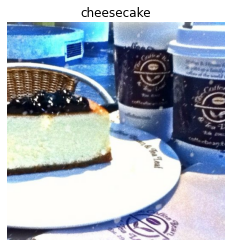

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create a preprocessing functions for our data

Neural network perfowm best when data is in a certain way (i.e batched , normalized etc)

What we know about our data  :     
* In 'unit8' data type
* Comprised of all different size tensors (different sized images)
* Not scaled 

What we know models like :
* data in 'float32' dtype (or mixed precision 'float16' and 'float32')

* For batches , Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled ( values b/w 0 & 1 also called normalized tensors generally performs better)


We are going to be using EfficientnetBX architecture

This means our function needs to :        
* Reshape our images  to all the same size
* Convert  the dtype of our image tensors from unit8 to float32

In [ ]:
#Make a function for preproceesing images

def preprocess_img(image,label,image_shape=224):
    

  image = tf.image.resize(image , [image_shape,image_shape])
  #image = image /255. #scale image
  return tf.cast(image,tf.float32),label # return (float_32 image,label) tuplee

In [ ]:
#preprocess a single sample _image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing : \n {image[:2]} ..... , \n Shape : {image.shape},\n Datatype : {image.dtype}")
print(f"Image after preprocessing : \n {preprocessed_img[:2]} ..... , \n Shape : {preprocessed_img.shape},\n Datatype : {preprocessed_img.dtype}")


Image before preprocessing : 
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]] ..... , 
 Shape : (512, 512, 3),
 Datatype : <dtype: 'uint8'>
Image after preprocessing : 
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]] ..... , 
 Shape : (224, 224, 3),
 Datatype : <dtype: 'float32'>


# Batch and prepare datasets
Help from the following guide  : https://www.tensorflow.org/guide/data 


In [ ]:
# Map preprocesssing function to training (and paraalizes)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
#Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size= 1000).batch(batch_size =32 ).prefetch(buffer_size = tf.data.AUTOTUNE)

#Map preprocessing data for test data
test_data = test_data.map(map_func = preprocess_img , num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size= tf.data.AUTOTUNE)



In [ ]:
train_data , test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks 
* TensorBoard callback to log training results(so we can vizualize them later if need be)

* ModelCheckPoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import  from helper_function.py)

from helper_functions import create_tensorboard_callback

# Create  ModelCheckpoint callback to save a model's progress during training 

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
tf.__version__

'2.7.0'

# BUILD FEATURE EXTRACTION MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create base Model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create functional model

inputs =layers.Input(shape=input_shape , name ="input_layer")

#Note Efficient Net BX have rescaling built in  if your model does not have on eyou can uses the layer sbelow
# x = preprocessing.Rescaling(1./255)(x)

x=base_model(inputs,training =False) # make sure layers which should be in inference model stay like that
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax" , dtype = tf.float32 , name = "softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

#compilr
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "float32">
normalization float32 <Policy "float32">
stem_conv_pad float32 <Policy "float32">
stem_conv float32 <Policy "float32">
stem_bn float32 <Policy "float32">
stem_activation float32 <Policy "float32">
block1a_dwconv float32 <Policy "float32">
block1a_bn float32 <Policy "float32">
block1a_activation float32 <Policy "float32">
block1a_se_squeeze float32 <Policy "float32">
block1a_se_reshape float32 <Policy "float32">
block1a_se_reduce float32 <Policy "float32">
block1a_se_expand float32 <Policy "float32">
block1a_se_excite float32 <Policy "float32">
block1a_project_conv float32 <Policy "float32">
block1a_project_bn float32 <Policy "float32">
block2a_expand_conv float32 <Policy "float32">
block2a_expand_bn float32 <Policy "float32">
block2a_expand_activation float32 <Policy "float32">


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

##Fit the featrure extraction model

If our goal is to fine-tune a pretrained model the general order of doing things is : 
* Build a feature extraction model (train a couple outpuut layers with base layer frozen)
* Fine tune some of the frozen layer 

In [ ]:
# Fit the featire extractioon model with call backs
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch = len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",experiment_name="efficientnetB5"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB5/20220109-161300


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8262 - accuracy: 0.5584WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 322s 128ms/step - loss: 1.8262 - accuracy: 0.5584 - val_loss: 1.2327 - val_accuracy: 0.6774
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2963 - accuracy: 0.6646WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 311s 130ms/step - loss: 1.2963 - accuracy: 0.6646 - val_loss: 1.1302 - val_accuracy: 0.6981
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1439 - accuracy: 0.7017WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 303s 127ms/step - loss: 1.1438 - accuracy: 0.7017 - val_loss: 1.0885 - val_accuracy: 0.7090


In [ ]:
result_feature_extraction=model.evaluate(test_data)

790/790 [==============================] - 94s 119ms/step - loss: 1.0825 - accuracy: 0.7080


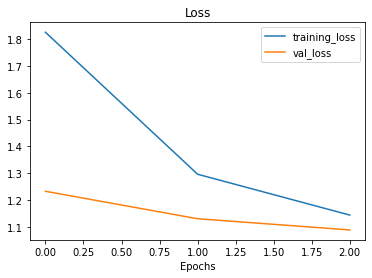

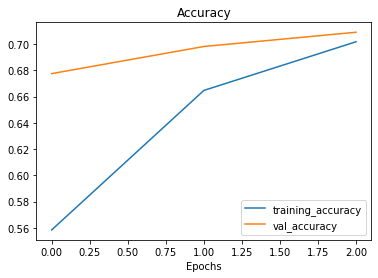

In [ ]:
plot_loss_curves(history_feature_extraction)

# SAVING MODEL LOCALLY 


In [ ]:
# Save model locally
model.save("saved_model/model_feature_extraction")

INFO:tensorflow:Assets written to: saved_model/model_feature_extraction/assets


INFO:tensorflow:Assets written to: saved_model/model_feature_extraction/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#Load Previously loaded model
loaded_model = tf.keras.models.load_model('saved_model/model_feature_extraction')

In [ ]:
#Evaluating  the loaded model on test data set
result_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 98s 121ms/step - loss: 1.0825 - accuracy: 0.7080


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## FINE -TUNNING

In [ ]:
base_model.trainable=True



In [ ]:


# Create  ModelCheckpoint callback to save a model's progress during training 
checkpoint_path_1 = "model_checkpoints/cp1.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_1,
                                                      monitor = "val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)



In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_fine_tunning= model.fit(train_data,
                                     epochs=10,
                                     steps_per_epoch=len(train_data),
                                     validation_data=test_data,
                                     validation_steps = int(0.15 * len(test_data) ),
                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",experiment_name="efficientnetB5_Fine_Tune"),
                                                  model_checkpoint],initial_epoch=history_feature_extraction.epoch[-1])

Saving TensorBoard log files to: training_logs/efficientnetB5_Fine_Tune/20220109-163449


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.7509WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1419s 592ms/step - loss: 0.9219 - accuracy: 0.7509 - val_loss: 0.8232 - val_accuracy: 0.7709
Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.8406WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1407s 593ms/step - loss: 0.5771 - accuracy: 0.8406 - val_loss: 0.7620 - val_accuracy: 0.7871
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.9064WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1417s 597ms/step - loss: 0.3261 - accuracy: 0.9064 - val_loss: 0.8460 - val_accuracy: 0.7910
Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9487WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1394s 588ms/step - loss: 0.1749 - accuracy: 0.9487 - val_loss: 0.9862 - val_accuracy: 0.7778
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9664WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1386s 584ms/step - loss: 0.1072 - accuracy: 0.9664 - val_loss: 1.0350 - val_accuracy: 0.7725
Epoch 8/10
2368/2368 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9746WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1393s 587ms/step - loss: 0.0802 - accuracy: 0.9746 - val_loss: 1.1006 - val_accuracy: 0.7778
Epoch 9/10
2368/2368 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1413s 596ms/step - loss: 0.0718 - accuracy: 0.9766 - val_loss: 1.1464 - val_accuracy: 0.7844
Epoch 10/10
2368/2368 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9804WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 1394s 588ms/step - loss: 0.0605 - accuracy: 0.9804 - val_loss: 1.2106 - val_accuracy: 0.7844


In [ ]:
result_fine_tuning = model.evaluate(test_data)

790/790 [==============================] - 93s 117ms/step - loss: 1.1821 - accuracy: 0.7852


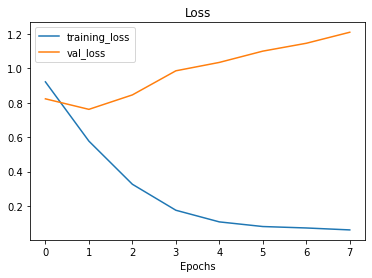

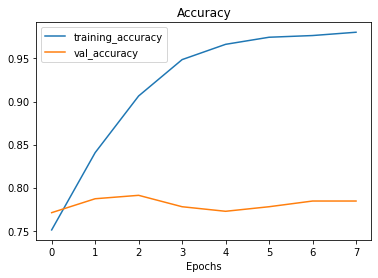

In [ ]:
plot_loss_curves(history_fine_tunning)

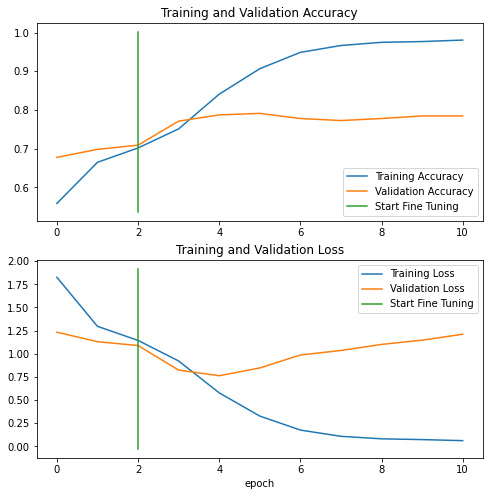

In [ ]:
compare_historys(original_history=history_feature_extraction,new_history=history_fine_tunning,initial_epochs=3)

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 89s 111ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([22, 49, 12,  7, 33, 52, 69, 54, 88, 50])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#Evaluating our models 



In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.009584158415841584

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


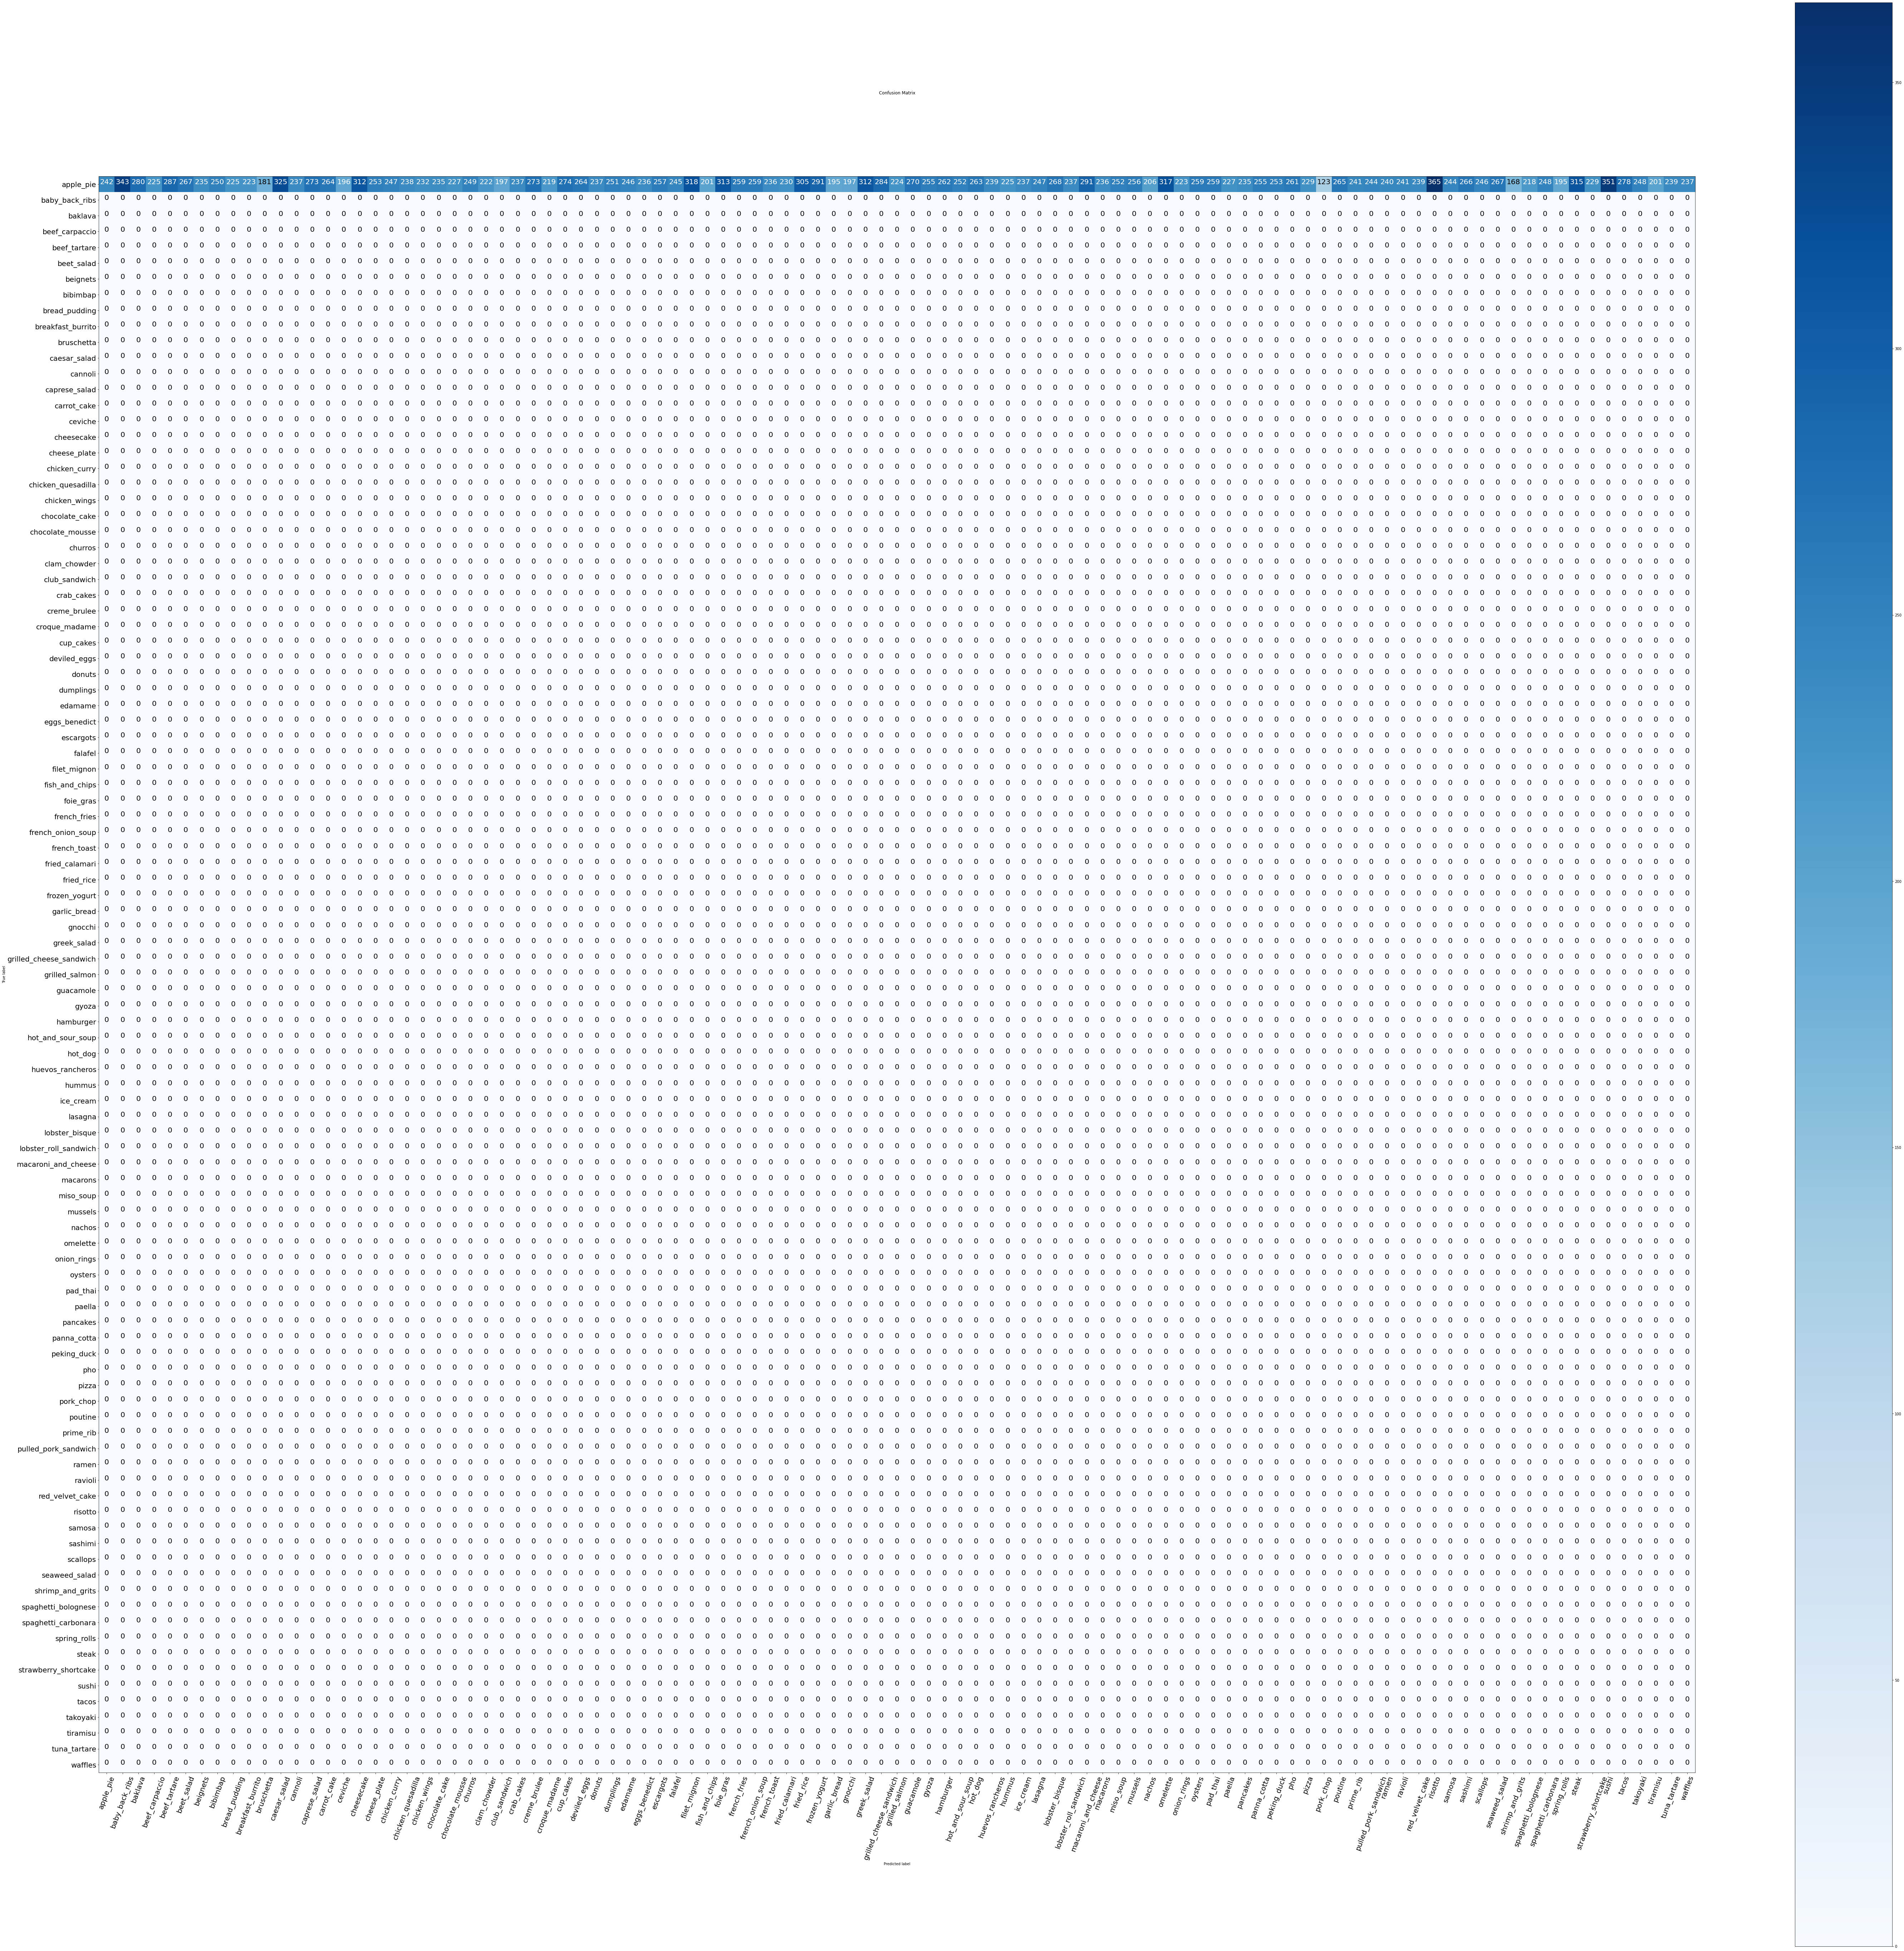

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')